In [1]:
from seirsplus.models import *
import networkx

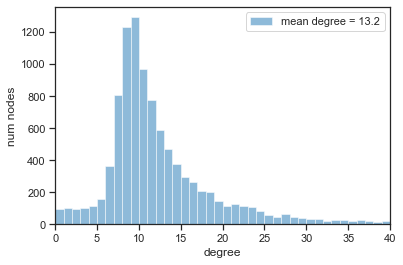

In [2]:
numNodes =10000
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=9)
# Baseline normal interactions:
G_normal     = custom_exponential_graph(baseGraph, scale=100)
plot_degree_distn(G_normal, max_degree=40)

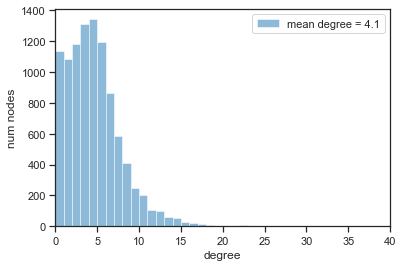

In [3]:
# Social distancing interactions:
G_distancing = custom_exponential_graph(baseGraph, scale=10)
plot_degree_distn(G_distancing, max_degree=40)

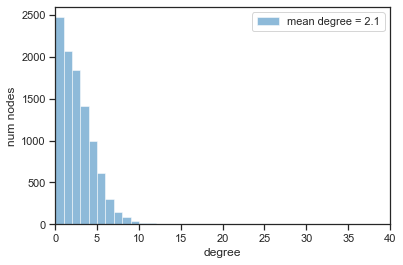

In [4]:
# Quarantine interactions:
G_quarantine = custom_exponential_graph(baseGraph, scale=5)
plot_degree_distn(G_quarantine, max_degree=40)

In [5]:
mumbai_cases = 2000
mumbai_population = 12500000

mumbai_cases_normalized = float(mumbai_cases/mumbai_population) * numNodes
mumbai_cases_normalized, np.ceil(mumbai_cases_normalized)

(1.6, 2.0)

Playing around with three main parameters:

1. infections_multiple (x):<br>
number of infections = x * number of detected infections (known)<br>
<br>
2. exposed_multiple (y):<br>
number of exposed = y * number of detected infections<br>
<br>
3. detected_exposed_multiple (z):<br>
number of detected exposed = z * number of detected infections<br>

In [6]:
infections_multiple = 3
exposed_multiple = 10
detected_exposed_multiple = 2

In [24]:
normalized_detected_infected_cases = np.ceil(mumbai_cases_normalized)

model = SEIRSNetworkModel(G       =G_distancing, 
                          beta    =0.155, # rate of transmission
                          sigma   =1/5.2, # rate of progression
                          gamma   =1/20, # rate of recovery
                          mu_I    =0.002, # rate of infection related mortality
                          mu_0    =0, # rate of baseline mortality
                          nu      =0, # rate of baseline birth
                          xi      =0, # rate of re-susceptibility
                          p       =0.1, # probability of global interactions (network locality) 
                          # p is 0.1 for G_distancing and 0.5 for G_normal
                          
                          Q       =G_quarantine, 
                          beta_D  =0.155, # rate of transmission for detected cases
                          sigma_D =1/5.2, # rate of progression for detected cases
                          gamma_D =1/12.39, # rate of recovery for detected cases
                          mu_D    =0.02, # rate of infection-related mortality for detected cases
                          theta_E =0.005, # rate of testing for exposed individuals
                          theta_I =0.05, # rate of testing for infected individuals
                          phi_E   =0.2, # rate of contact tracing testing for exposed individuals
                          phi_I   =0.2, # rate of contact tracing testing for infectious individuals
                          psi_E   =1.0, # probability of positive tests for exposed individuals
                          psi_I   =1.0, # probability of positive tests for infectious individuals
                          q       =0.1, # probability of global interactions for quarantined individuals
                          
                          initI   =infections_multiple * normalized_detected_infected_cases, # initial number of infectious individuals
                          initE   =exposed_multiple * normalized_detected_infected_cases, # initial number of exposed individuals
                          initD_E =detected_exposed_multiple * normalized_detected_infected_cases, # initial number of detected exposed individuals
                          initD_I =normalized_detected_infected_cases, # initial number of detected infectious individuals
                          initR   =0, # initial number of recovered individuals
                          initF   =0) # initial number of deceased individuals

In [25]:
checkpoints = {'t':       [15], # Assuming a 25 day lockdown after which G_normal represents the network graph
               'G':       [G_normal],
#                'beta':    [0.25],
#                'beta_D':  [0.25],
               'p':       [0.5], 
               'theta_E': [0.01], # Assuming rate of testing improves by the time lockdown ends (2x)
               'theta_I': [0.1], 
               'phi_E':   [0.1], # rate of contact tracing becomes difficult when the lockdown ends
               'phi_I':   [0.1]}

In [26]:
model.run(T = 100, checkpoints=checkpoints)

t = 0.13
t = 10.22
[Checkpoint: Updating parameters]
t = 20.14
t = 30.01
t = 40.06
t = 50.01
t = 60.23
t = 70.02
t = 80.24
t = 90.08
t = 100.06


True

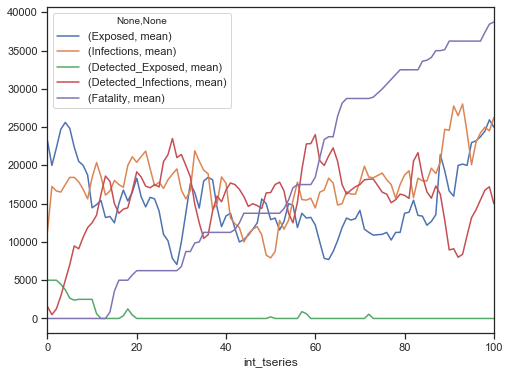

In [27]:
# pd.Series(model.numI).shape

S = model.numS  # time series of S counts
E = model.numE  # time series of E counts
I = model.numI  # time series of I counts
D_E = model.numD_E  # time series of D_E counts
D_I = model.numD_I  # time series of D_I counts
R = model.numR  # time series of R counts
F = model.numF  # time series of F counts
t = model.tseries  # time values corresponding to the above time series

result = pd.DataFrame(data = [S, E, I, D_E, D_I, R, F, t]).transpose()

result = result.rename(columns={0:'Susceptible', 1:'Exposed', 2:'Infections', 3:'Detected_Exposed',
                               4:'Detected_Infections', 5:'Recovered', 6:'Fatality', 7:'tseries'})

col_names = [ 'Exposed', 'Infections',
                'Detected_Exposed','Detected_Infections','Fatality']

for i in col_names:
    result[i] = result[i] * float(mumbai_population/numNodes)

result['int_tseries'] = result['tseries'].astype(int)


result.groupby('int_tseries')[col_names].agg(['mean']).plot(figsize=(8,6))

# result.groupby('int_tseries')['Exposed'].agg(['mean']).plot()
# result.groupby('int_tseries')['Infections'].agg(['mean']).plot()



Result from the model without any normalizations

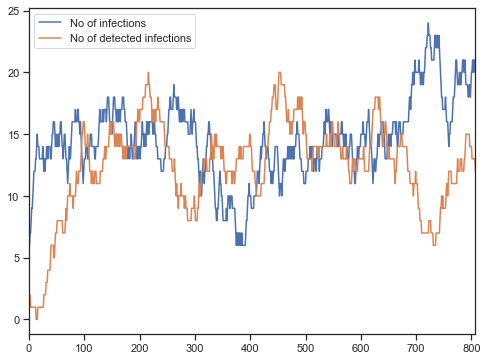

In [28]:
pd.Series(model.numI).plot(label ='No of infections', figsize=(8, 6))
pd.Series(model.numD_I).plot(label = 'No of detected infections')
plt.legend()
plt.show()

In [30]:
# model.figure_infections(vlines=checkpoints['t'], ylim=0.01)